In [1]:
import numpy as np
import scipy as sp
import h5py
import pandas as pd
import os
import glob
import importlib
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import false_discovery_control as fdr
from utils.Surf import roi2gii, vertex2gii
import utils.Vis
importlib.reload(utils.Vis)
from utils.Vis import plot_maps

/home/ali/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Config parameters
root = "/home/ali/graham-akhanf/EpLink/Eplink"
results_path = os.path.join(root,"ISC-pipeline","results","{dataset}","looISC","control")
atlases_path = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K')

atlases = ['none', 'Glasser_2016', 'Desikan', 'Schaefer2018_17Networks_400', 'Yan2023_17Networks_400']
atlases_aliases = ['Vertex', 'Glasser 2016', 'Desikan', 'Schaefer 2018', 'Yan 2023']

datasets = ["eplink-p2", "eplink-p3"]
task_dataset = {'eplink-p2': 'hitchcock', 'eplink-p3': 'movie'}
resampled_dataset = {'eplink-p2': 'N', 'eplink-p3': 'Y'}

fwhm = 0
confounds_idx = 1

file_pattern = "looISC_task-{task}_hemi-{{hemi}}_fwhm-{fwhm}_confounds-{confounds_idx}_resampled-{resampled}_atlas-{atlas}.h5"

In [3]:
def load_data_loo(file_format):
    data = dict()
    for h in ['L', 'R']:
        fpath = file_format.format(hemi=h)
        with h5py.File(fpath, 'r') as f:
                # Load the pairwise ISCs
                data[h] = f['loo_ISC'][:]
    return data

In [4]:
# Load atlas labels

atlas_labels = dict()

for atlas in atlases[1:]:
    atlas_path = os.path.join(atlases_path, f'{atlas}.32k.{{hemi}}.label.gii')
    labels = nib.load(atlas_path.format(hemi='L')).labeltable.get_labels_as_dict()
    labels_list_L = [None] * len(labels)
    for k,v in labels.items():
        labels_list_L[k] = v
    labels = nib.load(atlas_path.format(hemi='R')).labeltable.get_labels_as_dict()
    labels_list_R = [None] * len(labels)
    for k,v in labels.items():
        labels_list_R[k] = v
    
    atlas_labels[atlas] = labels_list_L + labels_list_R

atlas_labels['Desikan'].remove('corpuscallosum')
atlas_labels['Desikan'].remove('corpuscallosum')

atlas_labels['Yan2023_17Networks_400'] = atlas_labels['Yan2023_17Networks_400'][:402]
atlas_labels['Yan2023_17Networks_400'][201:] = atlas_labels['Yan2023_17Networks_400'][200:401]
atlas_labels['Yan2023_17Networks_400'][200] = atlas_labels['Yan2023_17Networks_400'][0]

# Phase II and III

## Generate leave-one-out mean maps

In [8]:
mean_ISC = dict()
all_ISC = dict()
for dataset in datasets:
    task = task_dataset[dataset]
    for i, atlas in enumerate(atlases):
        file_format = os.path.join(results_path, file_pattern).format(dataset=dataset, task=task, fwhm=fwhm, confounds_idx=confounds_idx, resampled = 'N', atlas=atlas)
        ISC = load_data_loo(file_format)

        ISC_mean = {k: v.mean(axis=0) for k,v in ISC.items()}
        mean_ISC[f'{dataset}-{atlas}'] = np.concatenate([ISC_mean['L'], ISC_mean['R']])
        all_ISC[f'{dataset}-{atlas}'] = np.concatenate([ISC['L'], ISC['R']], axis=1) 

        output_path = os.path.join('.','surface_maps',f'{dataset}')
        if atlas == 'none':
            vertex2gii(ISC_mean, output_path, f'looISC_desc-mean_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')
        else:
            atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
            roi2gii(ISC_mean, atlasfile, output_path, f'looISC_desc-mean_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')

## Generate leave-one-out cv maps

In [11]:
cv = dict()
for dataset in datasets:
    task = task_dataset[dataset]
    for i, atlas in enumerate(atlases):
        file_format = os.path.join(results_path, file_pattern).format(dataset=dataset, task=task, fwhm=fwhm, confounds_idx=confounds_idx, resampled = 'N', atlas=atlas)
        ISC = load_data_loo(file_format)

        ISC_cv = {k: np.log(np.abs(v.std(axis=0)/v.mean(axis=0))) for k,v in ISC.items()}
        cv[f'{dataset}-{atlas}'] = np.concatenate([ISC_cv['L'], ISC_cv['R']]) 

        output_path = os.path.join('.','surface_maps',f'{dataset}')
        if atlas == 'none':
            vertex2gii(ISC_cv, output_path, f'looISC_desc-cv_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')
        else:
            atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
            roi2gii(ISC_cv, atlasfile, output_path, f'looISC_desc-cv_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')

## Summary figures

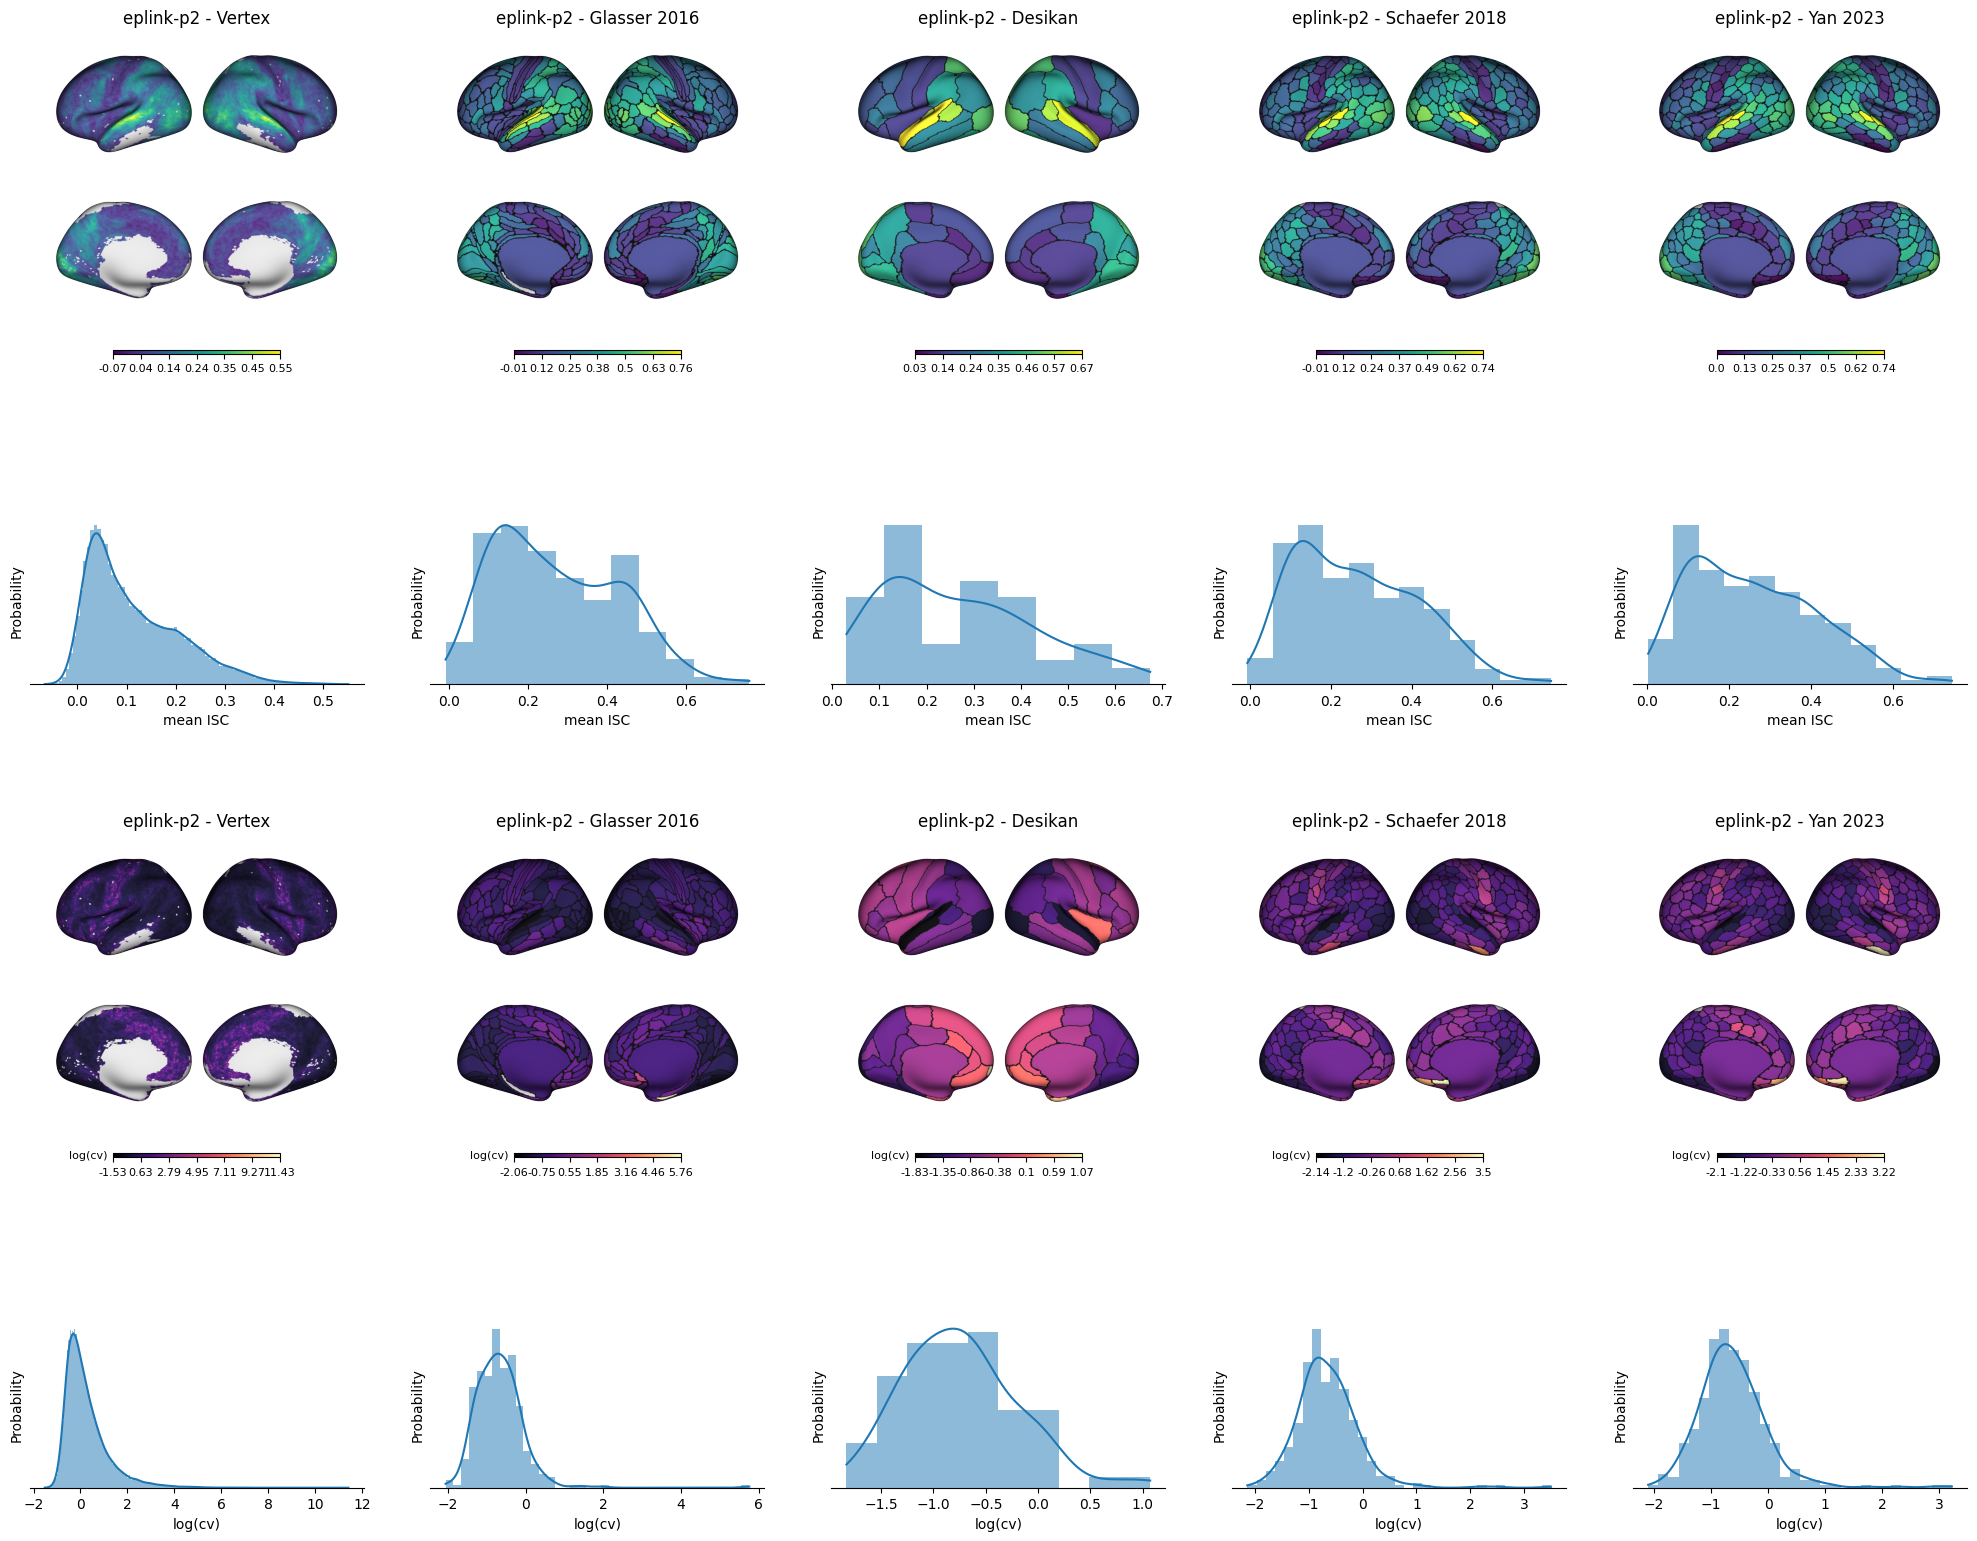

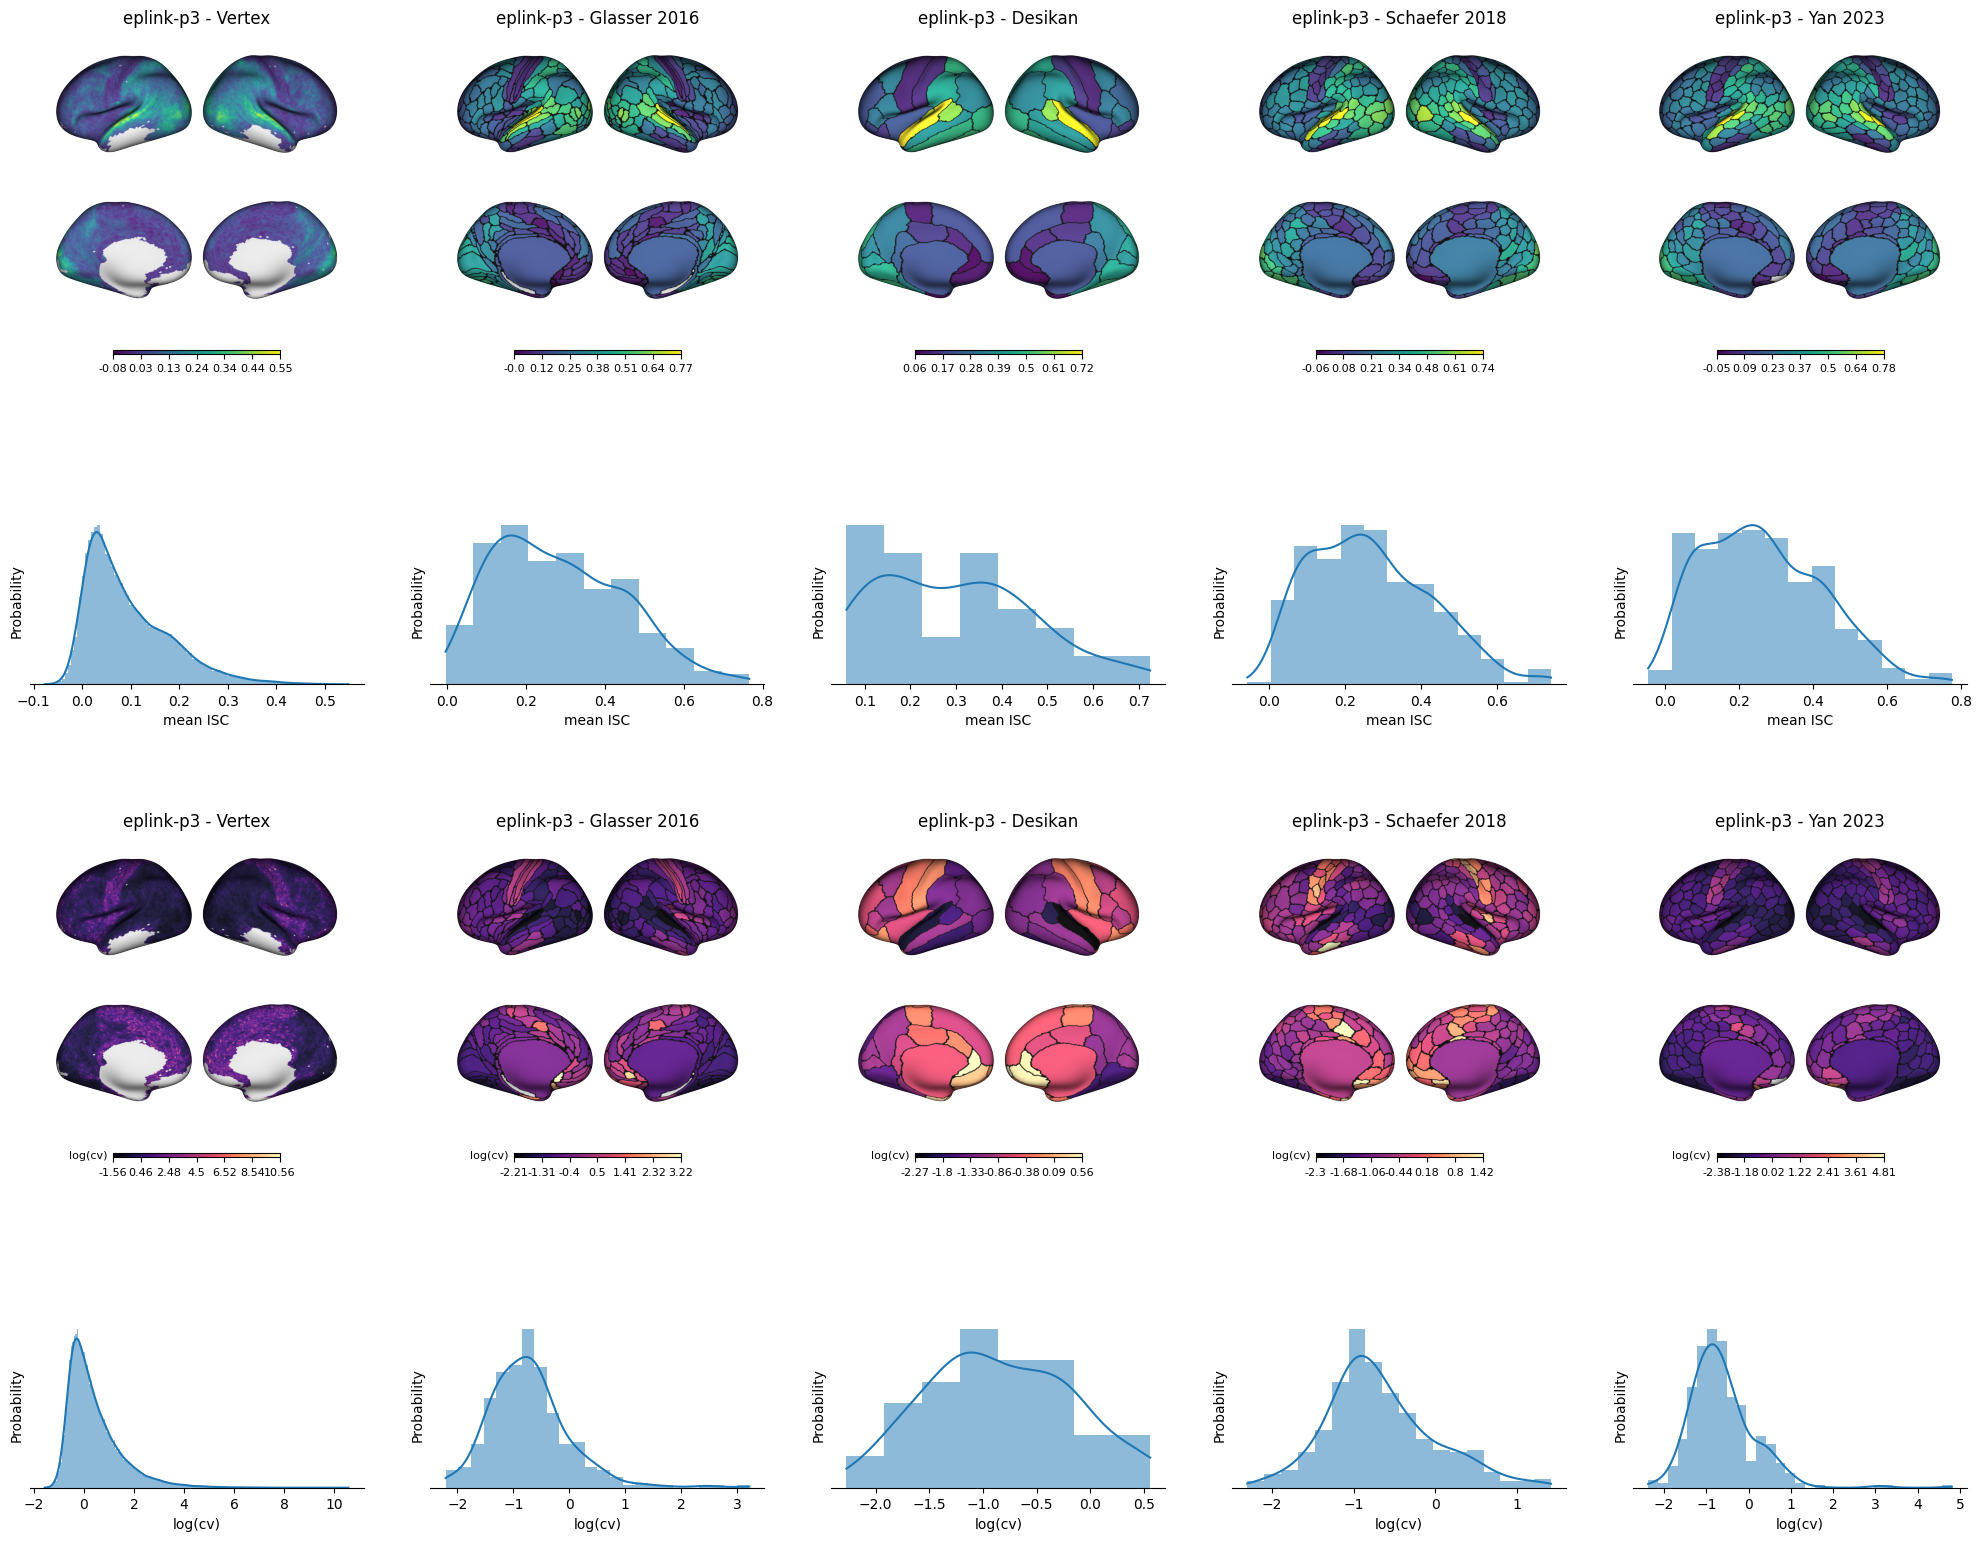

In [13]:
importlib.reload(utils.Vis)
from utils.Vis import plot_maps
for dataset in datasets:
    fig, axes = plt.subplots(4,5,figsize=(25,20))
    # plot ISC mean maps
    for i, atlas in enumerate(atlases):
        if atlas != 'none':
            atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
        else:
            atlasfile = None
        map_path = os.path.join('.','surface_maps',f'{dataset}',f'looISC_desc-mean_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_{{hemi}}.shape.gii')
        plot_maps(map_path, atlas=atlasfile, title=f'{dataset} - {atlases_aliases[i]}', ax=axes[0,i])
    # plot ISC mean histogram
    for i, atlas in enumerate(atlases):        
        ax = axes[1,i]

        sns.histplot(mean_ISC[f'{dataset}-{atlas}'], ec='None', stat='probability', kde=True, ax=ax)

        ax.set_box_aspect(0.5)
        # axes[3,i].set_xlim(0,1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # axes[s].spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xlabel('mean ISC')
        ax.set_yticks([])

    # plot ISC cv maps
    for i, atlas in enumerate(atlases):
        if atlas != 'none':
            atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
        else:
            atlasfile = None
        map_path = os.path.join('.','surface_maps',f'{dataset}',f'looISC_desc-cv_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_{{hemi}}.shape.gii')
        plot_maps(map_path, atlas=atlasfile, cmap='magma', title=f'{dataset} - {atlases_aliases[i]}', clabel='log(cv)', ax=axes[2,i])
    # plot ISC cv histogram
    for i, atlas in enumerate(atlases):
        # if atlas == 'none': 
        #     continue
        ax = axes[3,i]
        sns.histplot(cv[f'{dataset}-{atlas}'], ec='None', stat='probability', kde=True, ax=ax)
        ax.set_box_aspect(0.5)
        # axes[3,i].set_xlim(0,1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # axes[s].spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xlabel('log(cv)')
        ax.set_yticks([])
    

In [ ]:
# histogram of roi sizes
# flip color for cv

## ROIs with lowest cv

eplink-p2
['L_A5_ROI', 'R_A5_ROI', 'L_A4_ROI', 'R_V4_ROI', 'L_STSda_ROI']
['superiortemporal', 'superiortemporal', 'lateraloccipital', 'lateraloccipital', 'transversetemporal']
['17networks_LH_Aud_ST_5', '17networks_RH_VisualB_Striate_3', '17networks_LH_Aud_ST_4', '17networks_RH_Aud_ST_5', '17networks_LH_VisualB_Striate_3']
eplink-p3
['L_A4_ROI', 'R_A5_ROI', 'R_PBelt_ROI', 'L_PBelt_ROI', 'L_A5_ROI']
['superiortemporal', 'superiortemporal', 'bankssts', 'transversetemporal', 'inferiortemporal']
['17networks_LH_Aud_ST_5', '17networks_RH_Aud_ST_5', '17networks_RH_Aud_ST_4', '17networks_RH_Aud_ST_2', '17networks_RH_Aud_ST_1']


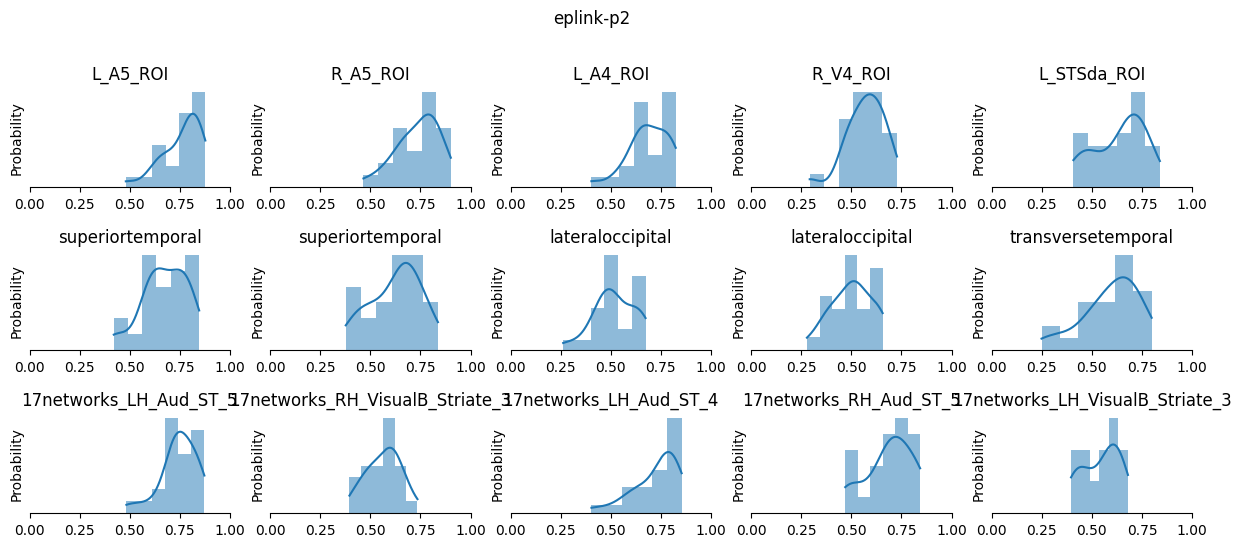

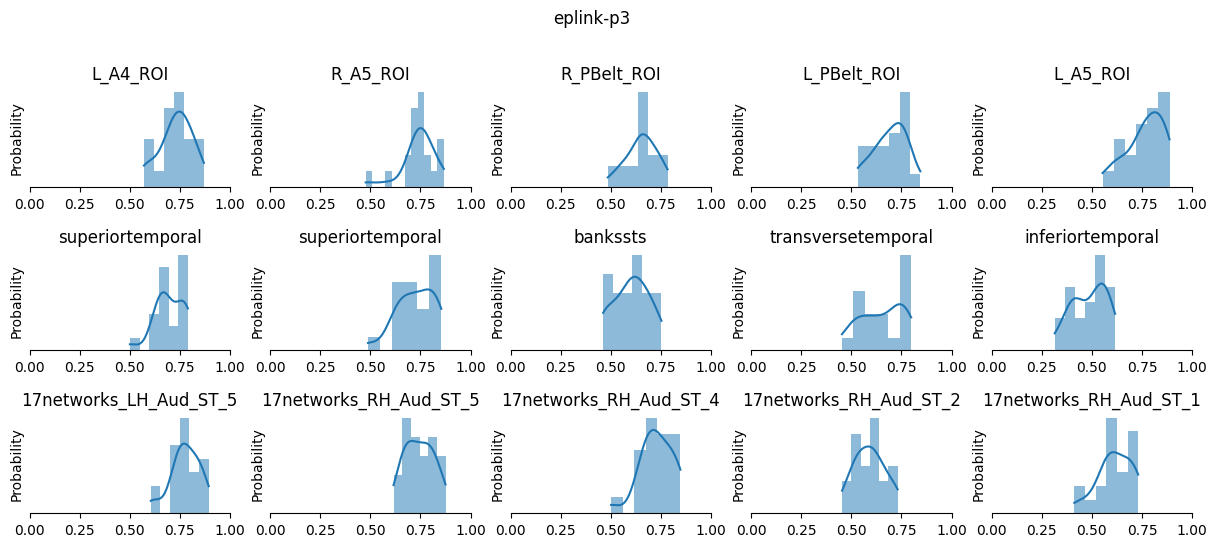

In [120]:
for dataset in datasets:
    print(dataset)
    fig, axes = plt.subplots(len(atlases)-1,5,figsize=(15,6))
    for i, atlas in enumerate(atlases[1:]):
        # Load labels
        atlas_path = os.path.join(atlases_path, f'{atlas}.32k.{{hemi}}.label.gii')
        labels = nib.load(atlas_path.format(hemi='L')).labeltable.get_labels_as_dict()
        labels_R = nib.load(atlas_path.format(hemi='R')).labeltable.get_labels_as_dict()
        n_rois = len(labels)
        for r in range(n_rois):
            labels[r+n_rois] = labels_R[r]

        # ind = np.nanargmin(cv[f'{dataset}-{atlas}'])
        # print(f'{atlas}: {labels[ind]}')

        ind = np.argsort(cv[f'{dataset}-{atlas}'])
        print([labels[l] for l in ind[:5]])

        for s in range(5):
            ax = axes[i,s]
            sns.histplot(all_ISC[f'{dataset}-{atlas}'][:,ind[s]], stat='probability', ec=None, kde=True, ax=ax)
            # Turn off the box (frame) around the plot
            ax.set_title(labels[ind[s]])
            ax.set_box_aspect(0.5)
            ax.set_xlim(0,1)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # axes[s].spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])

    fig.suptitle(f'{dataset}')

In [5]:
# Helper functions
def get_dimensions(filepath):
    """Extract dimensions of data from h5 data."""
    # Check file extension
    ext = os.path.splitext(filepath)[-1]
    
    # h5 file
    if ext == '.h5': 
        # Open the HDF5 file
        with h5py.File(filepath, 'r') as f:
            # Load the parcellated data
            data = f['parcellated_data'][:]
            # Return data dimensions
            n_rois, n_vol = data.shape
    
    # gii file
    elif ext == '.gii':
        # Load the GIFTI file by nibabel
        gii = nib.load(filepath)
        # Return data dimensions
        n_rois = gii.darrays[0].data.shape[0]
        n_vol = len(gii.darrays)
    
    return n_rois, n_vol

def load_HDF(filepath, n_vols):
    """Load data stored in the HDF files given the runs dataframe."""
    with h5py.File(filepath, 'r') as f:
            # Load the parcellated data
            data = f['parcellated_data'][:]
            data = data[:,:n_vols] # Ignoring excessive volumes
    # Returns data with shape ROI x Time
    return data

def load_gii(filepath, n_vols):
    func_gii = nib.load(filepath)
    data = np.vstack([darray.data for darray in func_gii.darrays[:n_vols]]).T
    # Returns data with shape Vertex x Time
    return data

def load_runs(runs_df, n_vols):
    # Loading only the last run
    fp = runs_df['full_path'].iloc[-1]
    # Checking file extension
    ext = os.path.splitext(fp)[-1]

    # h5 file
    if ext == '.h5':
        data = load_HDF(fp, n_vols)
    # gii file
    elif ext == '.gii':
        data = load_gii(fp, n_vols)
    
    return data

def get_info(filepath):
    """Extract subject, hemi, task, run, fwhm, confounds,
      rois, and number of volumes from a given file."""
    # Get file name
    basename = os.path.basename(filepath)
    # Split file name by '_'
    parts = basename.split('_')
    # Info dictionary
    info = {}
    # Parse file name
    for part in parts:
        info['full_path'] = filepath

        if part.startswith('sub-'):
            info['subject'] = part.split('sub-')[1]
        elif part.startswith('hemi-'):
            info['hemi'] = part.split('hemi-')[1]
        elif part.startswith('task-'):
            info['task'] = part.split('task-')[1]
        elif part.startswith('run-'):
            info['run'] = part.split('run-')[1]
        elif part.startswith('fwhm-'):
            info['fwhm'] = part.split('fwhm-')[1]
        elif part.startswith('confounds-'):
            info['confounds'] = part.split('confounds-')[1].split('_')[0]  # Assuming confounds is the last part before the file extension

    # Get dimensions for stored data    
    info['n_roi'], info['n_vol'] = get_dimensions(filepath)
    
    return info

def build_dataframe(directory, pattern=None):
    """Build a dataframe from files in the directory and its subdirectories."""
    # Default Pattern for search
    if pattern == None:
        subject, hemi, task, run, fwhm, confounds = ('*', '*', '*', '*', 0, 1)
        pattern = f"sub-{subject}_hemi-{hemi}_task-{task}_run-{run}_space-fsLR_den-32k_desc-denoised_fwhm-{fwhm}_confounds-{confounds}_atlas-glasser.h5"
    
    pattern = os.path.join(directory, 'sub-*', 'func', pattern)
    # Get all files matching the pattern
    files = glob.glob(pattern, recursive=True)
    # Building the dataframe
    df = pd.DataFrame([get_info(file) for file in files])
    
    return df

In [176]:
# Load files data
data = []
for subj in controls:
    # Filter subject files 
    df_s = df[df['subject'] == subj]
    # Load runs
    data.append(load_runs(df_s, target_volumes))

# Stacking subjects data (Subject, Unit, Time)
data = np.stack(data)

# Combined phases

## Generate maps and figures

In [5]:
results_path = os.path.join(root, 'results', 'phases_combined', 'looISC')
file_pattern = "looISC_hemi-{hemi}_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}.h5"
perm_results_path = os.path.join('.', 'results', 'phases_combined', 'looISC')

mean_ISC = dict()
all_ISC = dict()
cv = dict()

for i, atlas in enumerate(atlases[1:]):
    file_format = os.path.join(results_path, file_pattern).format(hemi='{hemi}', fwhm=fwhm, confounds_idx=confounds_idx, atlas=atlas)
    ISC = load_data_loo(file_format)
    file_format = os.path.join(perm_results_path, 'permutations_'+file_pattern).format(hemi='{hemi}', fwhm=fwhm, confounds_idx=confounds_idx, atlas=atlas)
    ISC_perm = dict()
    for h in ['L', 'R']:
        fpath = file_format.format(hemi=h)
        with h5py.File(fpath, 'r') as f:
                # Load the pairwise ISCs
                ISC_perm[h] = f['permutations_loo_ISC'][:]

    # ISC_mean = {k: v.mean(axis=0) for k,v in ISC.items()}
    mean_ISC[f'{atlas}'] = np.concatenate([ISC['L'].mean(axis=0), ISC['R'].mean(axis=0)])
    all_ISC[f'{atlas}'] = np.concatenate([ISC['L'], ISC['R']], axis=1) 
    ISC_cv = {k: np.log(np.abs(v.std(axis=0)/v.mean(axis=0))) for k,v in ISC.items()}
    cv[f'{atlas}'] = np.concatenate([ISC_cv['L'], ISC_cv['R']]) 

    ISC_perm_concat = np.concatenate((ISC_perm['L'], ISC_perm['R']), axis=2)
    mdist = ISC_perm_concat.mean(axis=1)
    pval = (mdist[1:,:] > mdist[0,:]).mean(axis=0)
    pval_adjusted = fdr(pval, method='bh')
    sig = pval < 0.001/360

    temp = mdist[0,:]
    temp[~sig] = np.nan
    
    n_rois = temp.shape[0]
    ISC_mean = {'L': temp[:int(n_rois/2)], 'R':temp[int(n_rois/2):]}

    output_path = os.path.join('.','surface_maps','phases_combined')
    if atlas == 'none':
        print('!')# vertex2gii(ISC_mean, output_path, f'looISC_desc-mean_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')
    else:
        atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
        roi2gii(ISC_mean, atlasfile, output_path, f'looISC_desc-mean_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')
        roi2gii(ISC_cv, atlasfile, output_path, f'looISC_desc-cv_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}')

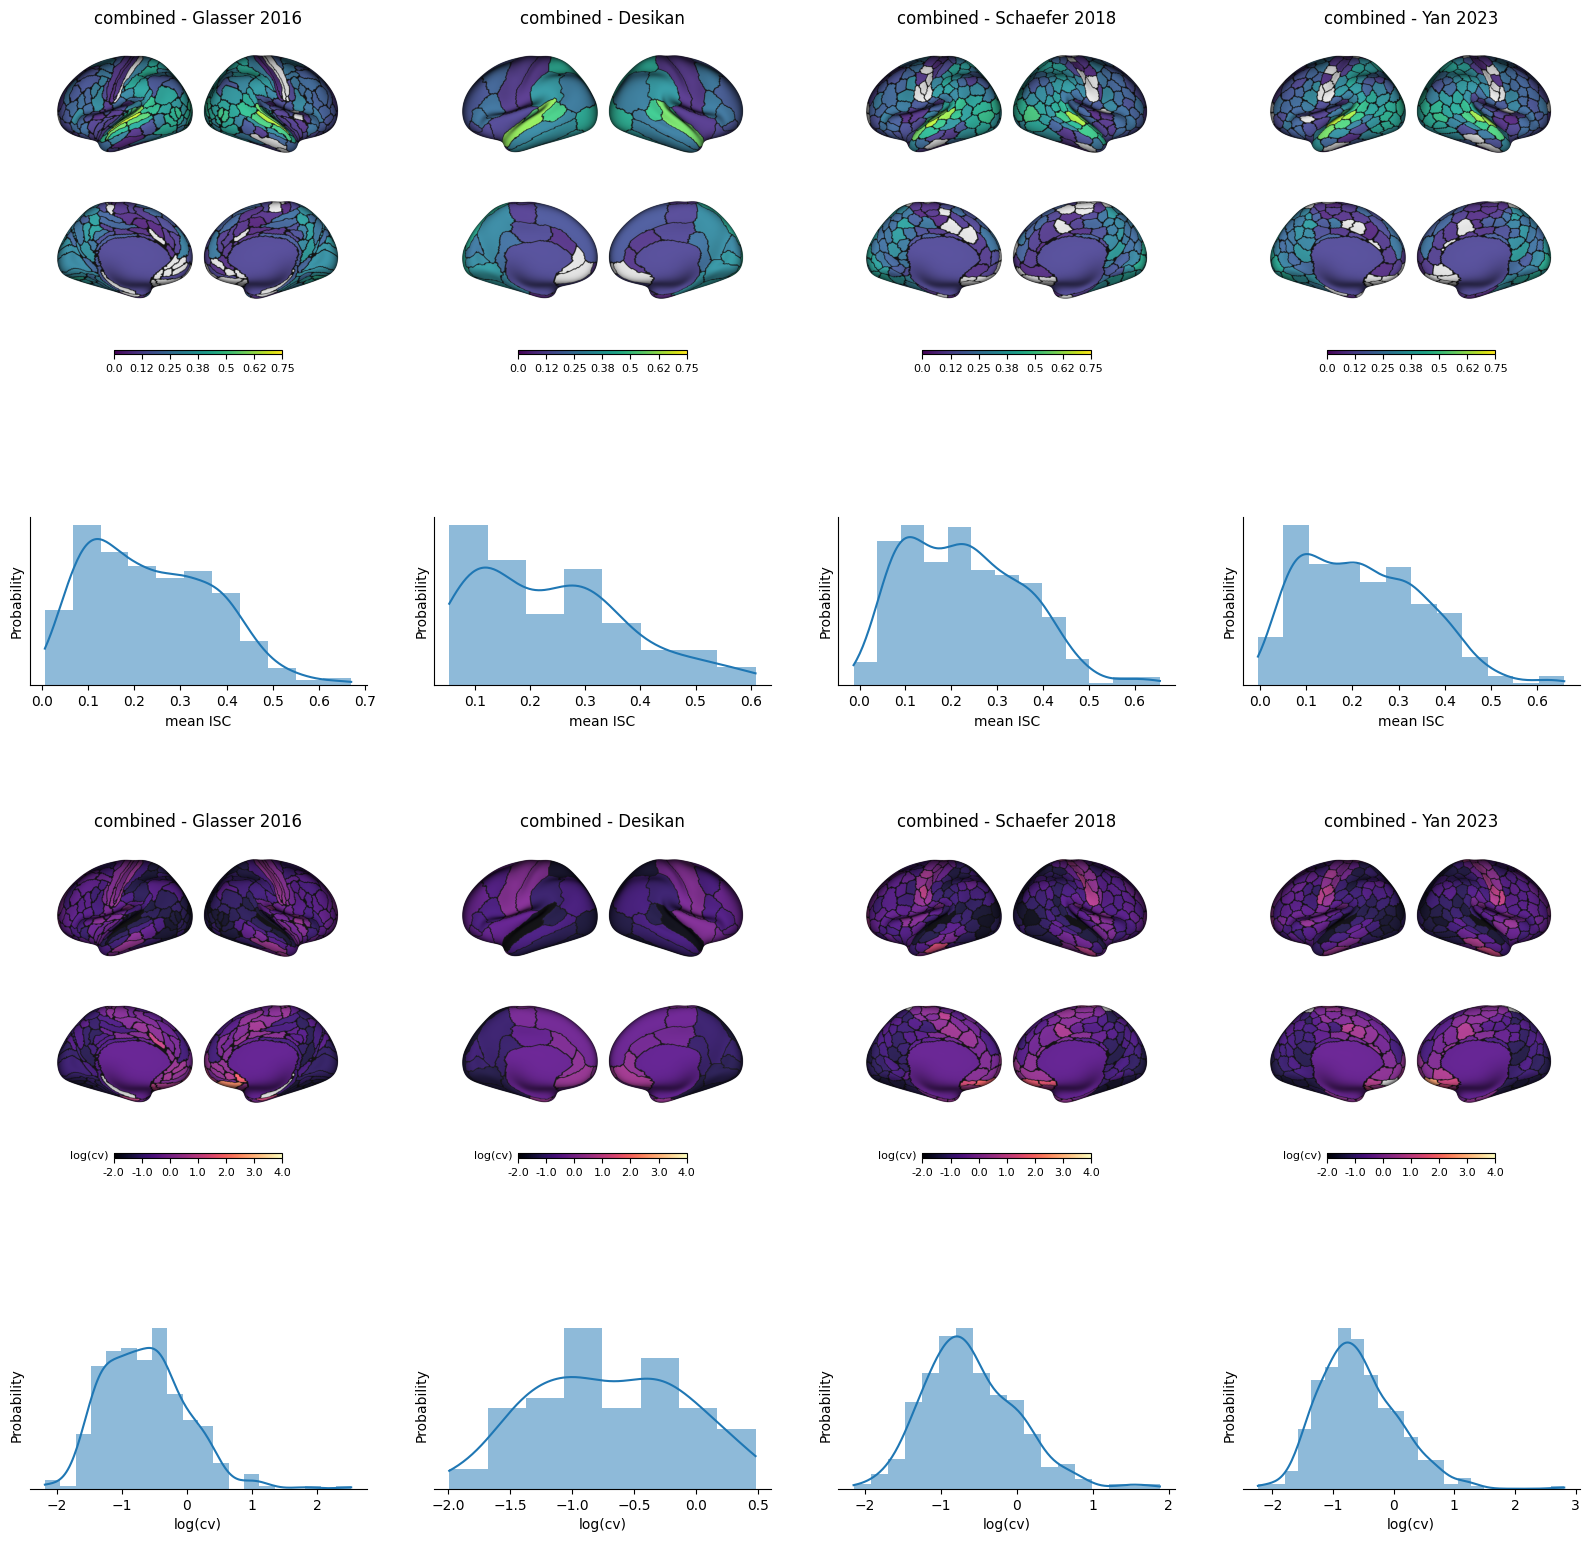

In [6]:
clim = [0, 0.75]

importlib.reload(utils.Vis)
from utils.Vis import plot_maps
fig, axes = plt.subplots(4,4,figsize=(20,20))
# plot ISC mean maps
for i, atlas in enumerate(atlases[1:]):
    if atlas != 'none':
        atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
    else:
        atlasfile = None
    map_path = os.path.join('.','surface_maps','phases_combined',f'looISC_desc-mean_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_{{hemi}}.shape.gii')
    plot_maps(map_path, atlas=atlasfile, title=f'combined - {atlases_aliases[i+1]}', ax=axes[0,i], range=clim)
# plot ISC mean histogram
for i, atlas in enumerate(atlases[1:]):        
    ax = axes[1,i]

    sns.histplot(mean_ISC[f'{atlas}'], ec='None', stat='probability', kde=True, ax=ax)

    ax.set_box_aspect(0.5)
    # axes[3,i].set_xlim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # axes[s].spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    ax.set_xlabel('mean ISC')
    ax.set_yticks([])

# plot ISC cv maps
for i, atlas in enumerate(atlases[1:]):
    if atlas != 'none':
        atlasfile = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K',f'{atlas}.32k.{{hemi}}.label.gii')
    else:
        atlasfile = None
    map_path = os.path.join('.','surface_maps','phases_combined',f'looISC_desc-cv_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_{{hemi}}.shape.gii')
    plot_maps(map_path, atlas=atlasfile, cmap='magma', title=f'combined - {atlases_aliases[i+1]}', clabel='log(cv)', ax=axes[2,i], range=[-2,4])
# plot ISC cv histogram
for i, atlas in enumerate(atlases[1:]):
    # if atlas == 'none': 
    #     continue
    ax = axes[3,i]
    sns.histplot(cv[f'{atlas}'], ec='None', stat='probability', kde=True, ax=ax)
    ax.set_box_aspect(0.5)
    # axes[3,i].set_xlim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # axes[s].spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('log(cv)')
    ax.set_yticks([])

# TODO: same scales for colorbars and histplots
# TODO: for ROIs with high ISC mean plot histogram

In [ ]:
# TODO: kstest of cv histograms

In [7]:
results_path = os.path.join(root, 'results', 'phases_combined', 'looISC')
file_pattern = "looISC_hemi-{hemi}_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}_patients.h5"

patients_ISC = dict()
for i, atlas in enumerate(atlases[1:]):
    file_format = os.path.join(results_path, file_pattern).format(hemi='{hemi}', fwhm=fwhm, confounds_idx=confounds_idx, atlas=atlas)
    ISC_p = load_data_loo(file_format)
    patients_ISC[atlas] = np.concatenate([ISC_p['L'], ISC_p['R']],axis=1) 

['R_A5_ROI', 'L_A5_ROI', 'L_A4_ROI', 'L_V3CD_ROI', 'L_LBelt_ROI']
['superiorparietal', 'superiorfrontal', 'temporalpole', 'superiorfrontal', 'frontalpole']
['label-197', 'label-195', 'label-198', 'label-63', 'label-46']
['17networks_LH_Aud_ST_5', '17networks_RH_Aud_ST_5', '17networks_RH_Aud_ST_6', '17networks_LH_Aud_ST_4', '17networks_LH_VisualA_ExStr_1']


Text(0.5, 0.98, 'phase II and phase III combined')

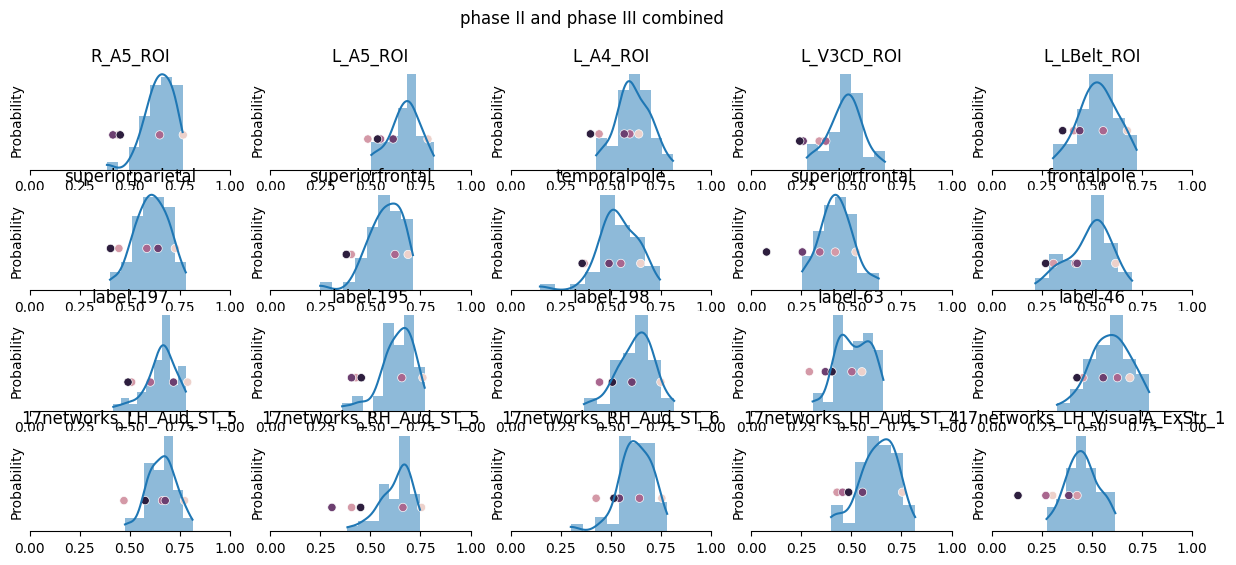

In [8]:
fig, axes = plt.subplots(len(atlases)-1,5,figsize=(15,6))
for i, atlas in enumerate(atlases[1:]):
    # Load labels
    atlas_path = os.path.join(atlases_path, f'{atlas}.32k.{{hemi}}.label.gii')
    labels = nib.load(atlas_path.format(hemi='L')).labeltable.get_labels_as_dict()
    labels_R = nib.load(atlas_path.format(hemi='R')).labeltable.get_labels_as_dict()
    n_rois = len(labels)
    for r in range(n_rois):
        labels[r+n_rois] = labels_R[r]

    # ind = np.nanargmin(cv[f'{dataset}-{atlas}'])
    # print(f'{atlas}: {labels[ind]}')

    ind = np.argsort(cv[f'{atlas}'])
    print([labels[l] for l in ind[:5]])


    for s in range(5):
        ax = axes[i,s]
        sns.histplot(all_ISC[f'{atlas}'][:,ind[s]], stat='probability', ec=None, kde=True, ax=ax)
        sns.scatterplot(x=patients_ISC[f'{atlas}'][:5,ind[s]], y=0.1, hue=np.arange(5), legend=False, ax=ax)
        # Turn off the box (frame) around the plot
        ax.set_title(labels[ind[s]])
        ax.set_box_aspect(0.5)
        ax.set_xlim(0,1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # axes[s].spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])

fig.suptitle('phase II and phase III combined')

In [9]:
from scipy.stats import ks_2samp
# ks test accross atlases mean ISC
for i in range(len(atlases)-1):
    for j in range(i+1,len(atlases)-1):
        print(ks_2samp(all_ISC[atlases[i+1]].mean(axis=0),all_ISC[atlases[j+1]].mean(axis=0)))


KstestResult(statistic=0.07995264404104183, pvalue=0.8141160388776316, statistic_location=0.3412828275727932, statistic_sign=-1)
KstestResult(statistic=0.05061708034413567, pvalue=0.6876583977592154, statistic_location=0.25691283343343785, statistic_sign=-1)
KstestResult(statistic=0.05928918941205574, pvalue=0.489809643340992, statistic_location=0.3474994820401116, statistic_sign=-1)
KstestResult(statistic=0.06823027718550106, pvalue=0.9233768344208289, statistic_location=0.415583659673849, statistic_sign=-1)
KstestResult(statistic=0.0828002842928216, pvalue=0.7734314164476966, statistic_location=0.0807191325586459, statistic_sign=-1)
KstestResult(statistic=0.03731343283582089, pvalue=0.9427601716650833, statistic_location=0.22773334678806087, statistic_sign=-1)


## Dataframe approach

In [10]:
results_path = os.path.join(root, 'results', 'phases_combined', 'looISC')
perm_results_path = os.path.join('.', 'results', 'phases_combined', 'looISC')
ISC_file_pattern = "looISC_hemi-{hemi}_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}.h5"
atlas = atlases[1]


print(f'Loading atlas:{atlas}')

file_format = os.path.join(results_path, ISC_file_pattern).format(hemi='{hemi}', fwhm=fwhm, confounds_idx=confounds_idx, atlas=atlas)
# Load controls ISCs
print('... controls ...')
ISC_con = load_data_loo(file_format)
print('done!')
print('... patients ...')
# Load patients ISCs
ISC_pat = load_data_loo(file_format[:-3]+'_patients.h5')
print('done!')
# Load permutations
print('... permutations ...')
file_format = os.path.join(perm_results_path, 'permutations_'+ISC_file_pattern).format(hemi='{hemi}', fwhm=fwhm, confounds_idx=confounds_idx, atlas=atlas)
ISC_perm = dict()
for h in ['L', 'R']:
    fpath = file_format.format(hemi=h)
    with h5py.File(fpath, 'r') as f:
            # Load the pairwise ISCs
            ISC_perm[h] = f['permutations_loo_ISC'][:]
print('done!')

ISC_con_concat = np.concatenate((ISC_con['L'], ISC_con['R']), axis=1)
ISC_pat_concat = np.concatenate((ISC_pat['L'], ISC_pat['R']), axis=1)
ISC_perm_concat = np.concatenate((ISC_perm['L'], ISC_perm['R']), axis=2)
mdist = ISC_perm_concat.mean(axis=1)
pval = (mdist[1:,:] > mdist[0,:]).mean(axis=0)
pval_adjusted = fdr(pval, method='bh')

Loading atlas:Glasser_2016
... controls ...
done!
... patients ...
done!
... permutations ...
done!


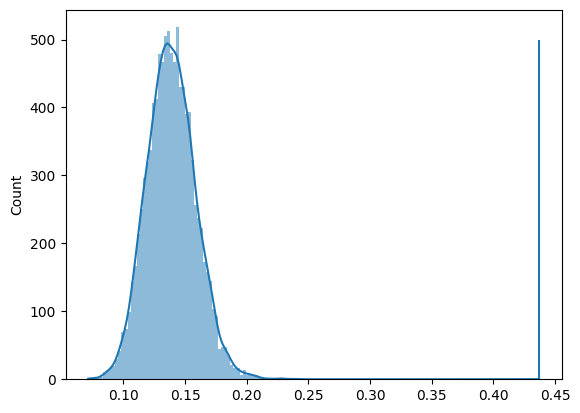

In [11]:
roi = 2
mobs = ISC_con_concat.mean(axis=0)
mdist = ISC_perm_concat.mean(axis=1)
sns.histplot(mdist[:,roi],ec=None,kde=True)
plt.vlines(mobs[roi],0,500)

In [12]:
mdist = ISC_perm_concat.mean(axis=1)
pval = (mdist[1:,:] > mdist[0,:]).mean(axis=0)
pval_adjusted = fdr(pval, method='bh')
np.sum(pval_adjusted<.001)

347

In [13]:
file_format = os.path.join(perm_results_path, 'permutations_'+ISC_file_pattern).format(hemi='{hemi}', fwhm=fwhm, confounds_idx=confounds_idx, atlas=atlas)
fpath = file_format.format(hemi='L')
with h5py.File(fpath, 'r') as f:
    shift_values = f['shift_values'][:]

shift_values

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 8,  0,  0, ...,  7, 16,  8],
       [21, 13,  0, ..., 20, 22, 23],
       ...,
       [22,  6,  3, ...,  8,  9,  2],
       [ 7, 13, 21, ..., 17, 15, 23],
       [ 9, 23, 10, ..., 20,  9, 23]])

In [14]:
results_path = os.path.join(root, 'results', 'phases_combined', 'looISC')
ISC_file_pattern = "looISC_hemi-{hemi}_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlas}.h5"

df = pd.DataFrame(columns=['atlas', 'ROI_idx', 'ROI_label',
                           'ISC_con_samp', 'ISC_con_mean', 'ISC_con_std', 'ISC_con_cv', 'ISC_con_nlogcv', 'ISC_con_median', 'significance',
                           'ISC_pat_samp', 'ISC_pat_mean', 'AUC', 'pat_zscore', 'zscore_mean', '#<-3', 'AUC_z'])

for i, atlas in enumerate(atlases[1:]):
    print(f'Loading atlas: {atlas}')

    file_format = os.path.join(results_path, ISC_file_pattern).format(hemi='{hemi}', fwhm=fwhm, confounds_idx=confounds_idx, atlas=atlas)
    # Load controls ISCs
    print('controls ...')
    ISC_con = load_data_loo(file_format)
    print('done!')
    # Load patients ISCs
    print('patients ...')
    ISC_pat = load_data_loo(file_format[:-3]+'_patients.h5')
    print('done!')
    # Load permutations
    print('permutations ...')
    file_format = os.path.join(perm_results_path, 'permutations_'+ISC_file_pattern).format(hemi='{hemi}', fwhm=fwhm, confounds_idx=confounds_idx, atlas=atlas)
    ISC_perm = dict()
    for h in ['L', 'R']:
        fpath = file_format.format(hemi=h)
        with h5py.File(fpath, 'r') as f:
                # Load the pairwise ISCs
                ISC_perm[h] = f['permutations_loo_ISC'][:]
    print('done!')

    ISC_con_concat = np.concatenate((ISC_con['L'], ISC_con['R']), axis=1)
    ISC_pat_concat = np.concatenate((ISC_pat['L'], ISC_pat['R']), axis=1)
    ISC_perm_concat = np.concatenate((ISC_perm['L'], ISC_perm['R']), axis=2)

    # Calculate pvalues + fdr correction
    mdist = ISC_perm_concat.mean(axis=1)
    pval = (mdist[1:,:] > mdist[0,:]).mean(axis=0)
    pval_adjusted = fdr(pval, method='bh')
    sig = pval_adjusted < 0.001
        

    for r, roi in enumerate(atlas_labels[atlas]):
        ISC_samp = ISC_con_concat[:,r]
        ISC_pat_samp = ISC_pat_concat[:,r]

        x = np.concatenate((ISC_pat_samp, ISC_samp))
        x[np.isnan(x)] = 0
        y = np.concatenate((-1*np.ones_like(ISC_pat_samp), np.ones_like(ISC_samp)))>0

        m = ISC_samp.mean()
        std = ISC_samp.std()
        cv = std/m
        con_z = (ISC_samp-m)/std
        pat_z = (ISC_pat_samp-m)/std

        x_z = np.concatenate((pat_z, con_z))
        x_z[np.isnan(x_z)] = 0

        df.loc[len(df.index)]= [atlas,r,roi,ISC_samp,m,std,cv,-np.log(cv),np.median(ISC_samp), sig[r],
                                ISC_pat_samp, ISC_pat_samp.mean(axis=0), roc_auc_score(y,x), pat_z, pat_z.mean(), (pat_z < -3).sum(), roc_auc_score(y,x_z)]
    
    

Loading atlas: Glasser_2016
controls ...
done!
patients ...
done!
permutations ...
done!
Loading atlas: Desikan
controls ...
done!
patients ...
done!
permutations ...
done!
Loading atlas: Schaefer2018_17Networks_400
controls ...
done!
patients ...
done!
permutations ...
done!


/tmp/ipykernel_446808/3109581678.py:59: RuntimeWarning: invalid value encountered in log
  df.loc[len(df.index)]= [atlas,r,roi,ISC_samp,m,std,cv,-np.log(cv),np.median(ISC_samp), sig[r],


Loading atlas: Yan2023_17Networks_400
controls ...
done!
patients ...
done!
permutations ...
done!


/tmp/ipykernel_446808/3109581678.py:59: RuntimeWarning: invalid value encountered in log
  df.loc[len(df.index)]= [atlas,r,roi,ISC_samp,m,std,cv,-np.log(cv),np.median(ISC_samp), sig[r],


In [15]:
df

atlas  ROI_idx                        ROI_label  \
0               Glasser_2016        0                              ???   
1               Glasser_2016        1                         L_V1_ROI   
2               Glasser_2016        2                        L_MST_ROI   
3               Glasser_2016        3                         L_V6_ROI   
4               Glasser_2016        4                         L_V2_ROI   
...                      ...      ...                              ...   
1231  Yan2023_17Networks_400      397        17networks_RH_VisualA_SPL   
1232  Yan2023_17Networks_400      398  17networks_RH_VisualA_TempOcc_1   
1233  Yan2023_17Networks_400      399  17networks_RH_VisualA_TempOcc_2   
1234  Yan2023_17Networks_400      400  17networks_RH_VisualA_TempOcc_3   
1235  Yan2023_17Networks_400      401  17networks_RH_VisualA_TempOcc_4   

                                           ISC_con_samp  ISC_con_mean  \
0     [0.2718106731228519, 0.22447862067258895, 0.22...      0.129111   
1     [0.538657812061426, 0.27669992041972646, 0.320...      0.295706   
2     [0.6339456958986326, 0.48806197345329255, 0.41...      0.436986   
3     [0.31195883807079544, 0.3227380744831124, 0.43...      0.212944   
4     [0.5562656670505894, 0.34852076417064665, 0.30...      0.309213   
...                                                 ...           ...   
1231  [0.5485600050198607, 0.39300554188752074, 0.42...      0.413579   
1232  [0.6067293304214605, 0.5183451498172087, 0.464...      0.449796   
1233  [0.5563149130537574, 0.45920965439026085, 0.53...      0.477912   
1234  [0.49210844793491, 0.34634582617735193, 0.4282...      0.398276   
1235  [0.5631642717506435, 0.326374401741277, 0.3632...      0.376014   

      ISC_con_std  ISC_con_cv  ISC_con_nlogcv  ISC_con_median  significance  \
0        0.080830    0.626053        0.468320        0.136578          True   
1        0.109870    0.371550        0.990071        0.304860          True   
2        0.101926    0.233247        1.455658        0.454206          True   
3        0.112137    0.526603        0.641308        0.222027          True   
4        0.104859    0.339114        1.081420        0.312432          True   
...           ...         ...             ...             ...           ...   
1231     0.080502    0.194648        1.636560        0.399593          True   
1232     0.116552    0.259123        1.350454        0.461392          True   
1233     0.094625    0.197996        1.619509        0.473040          True   
1234     0.114319    0.287036        1.248148        0.416197          True   
1235     0.095770    0.254699        1.367672        0.377193          True   

                                           ISC_pat_samp  ISC_pat_mean  \
0     [0.29642156430243544, 0.10908016791978549, 0.0...      0.133685   
1     [0.11693094261616747, 0.10981725161508207, 0.2...      0.233244   
2     [0.4939373607864065, 0.30321590124501424, 0.32...      0.406840   
3     [0.07479146093273359, 0.07251198147609789, 0.2...      0.171705   
4     [0.1697462134448946, 0.20273933164382935, 0.23...      0.253644   
...                                                 ...           ...   
1231  [0.4619391211088355, 0.3861735349694648, 0.277...      0.332677   
1232  [0.40447007809784447, 0.2541802682102623, 0.41...      0.409048   
1233  [0.509862152316682, 0.20957048542971712, 0.467...      0.447002   
1234  [0.48449968671622134, 0.29674759101193693, 0.3...      0.381919   
1235  [0.5240750661103813, 0.3573260760106222, 0.235...      0.327524   

           AUC                                         pat_zscore  \
0     0.487778  [2.0699087253782165, -0.24780960459582352, -1....   
1     0.633889  [-1.6271559387106644, -1.6919025905364322, -0....   
2     0.526667  [0.558754637581167, -1.312429161897036, -1.101...   
3     0.602222  [-1.2319984636273698, -1.2523260614845102, -0....   
4     0.610556  [-1.3300518775385834, -1.0154077375579706, -0....   
...        ...   

In [16]:
df = df[df['significance']]
df

atlas  ROI_idx                        ROI_label  \
0               Glasser_2016        0                              ???   
1               Glasser_2016        1                         L_V1_ROI   
2               Glasser_2016        2                        L_MST_ROI   
3               Glasser_2016        3                         L_V6_ROI   
4               Glasser_2016        4                         L_V2_ROI   
...                      ...      ...                              ...   
1231  Yan2023_17Networks_400      397        17networks_RH_VisualA_SPL   
1232  Yan2023_17Networks_400      398  17networks_RH_VisualA_TempOcc_1   
1233  Yan2023_17Networks_400      399  17networks_RH_VisualA_TempOcc_2   
1234  Yan2023_17Networks_400      400  17networks_RH_VisualA_TempOcc_3   
1235  Yan2023_17Networks_400      401  17networks_RH_VisualA_TempOcc_4   

                                           ISC_con_samp  ISC_con_mean  \
0     [0.2718106731228519, 0.22447862067258895, 0.22...      0.129111   
1     [0.538657812061426, 0.27669992041972646, 0.320...      0.295706   
2     [0.6339456958986326, 0.48806197345329255, 0.41...      0.436986   
3     [0.31195883807079544, 0.3227380744831124, 0.43...      0.212944   
4     [0.5562656670505894, 0.34852076417064665, 0.30...      0.309213   
...                                                 ...           ...   
1231  [0.5485600050198607, 0.39300554188752074, 0.42...      0.413579   
1232  [0.6067293304214605, 0.5183451498172087, 0.464...      0.449796   
1233  [0.5563149130537574, 0.45920965439026085, 0.53...      0.477912   
1234  [0.49210844793491, 0.34634582617735193, 0.4282...      0.398276   
1235  [0.5631642717506435, 0.326374401741277, 0.3632...      0.376014   

      ISC_con_std  ISC_con_cv  ISC_con_nlogcv  ISC_con_median  significance  \
0        0.080830    0.626053        0.468320        0.136578          True   
1        0.109870    0.371550        0.990071        0.304860          True   
2        0.101926    0.233247        1.455658        0.454206          True   
3        0.112137    0.526603        0.641308        0.222027          True   
4        0.104859    0.339114        1.081420        0.312432          True   
...           ...         ...             ...             ...           ...   
1231     0.080502    0.194648        1.636560        0.399593          True   
1232     0.116552    0.259123        1.350454        0.461392          True   
1233     0.094625    0.197996        1.619509        0.473040          True   
1234     0.114319    0.287036        1.248148        0.416197          True   
1235     0.095770    0.254699        1.367672        0.377193          True   

                                           ISC_pat_samp  ISC_pat_mean  \
0     [0.29642156430243544, 0.10908016791978549, 0.0...      0.133685   
1     [0.11693094261616747, 0.10981725161508207, 0.2...      0.233244   
2     [0.4939373607864065, 0.30321590124501424, 0.32...      0.406840   
3     [0.07479146093273359, 0.07251198147609789, 0.2...      0.171705   
4     [0.1697462134448946, 0.20273933164382935, 0.23...      0.253644   
...                                                 ...           ...   
1231  [0.4619391211088355, 0.3861735349694648, 0.277...      0.332677   
1232  [0.40447007809784447, 0.2541802682102623, 0.41...      0.409048   
1233  [0.509862152316682, 0.20957048542971712, 0.467...      0.447002   
1234  [0.48449968671622134, 0.29674759101193693, 0.3...      0.381919   
1235  [0.5240750661103813, 0.3573260760106222, 0.235...      0.327524   

           AUC                                         pat_zscore  \
0     0.487778  [2.0699087253782165, -0.24780960459582352, -1....   
1     0.633889  [-1.6271559387106644, -1.6919025905364322, -0....   
2     0.526667  [0.558754637581167, -1.312429161897036, -1.101...   
3     0.602222  [-1.2319984636273698, -1.2523260614845102, -0....   
4     0.610556  [-1.3300518775385834, -1.0154077375579706, -0....   
...        ...   

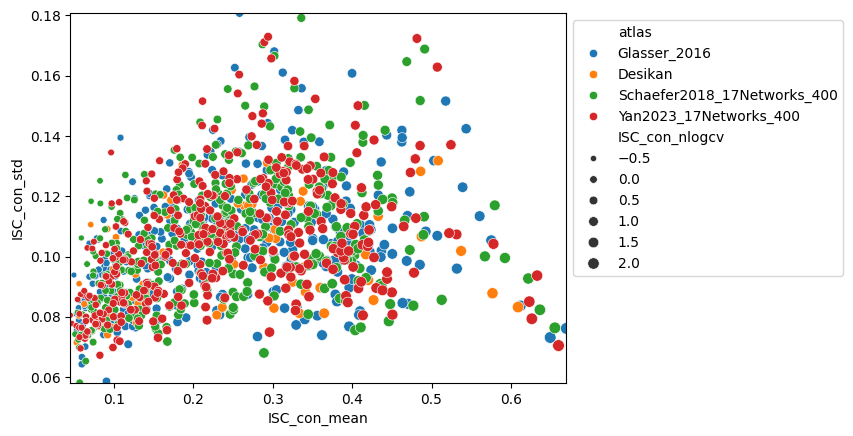

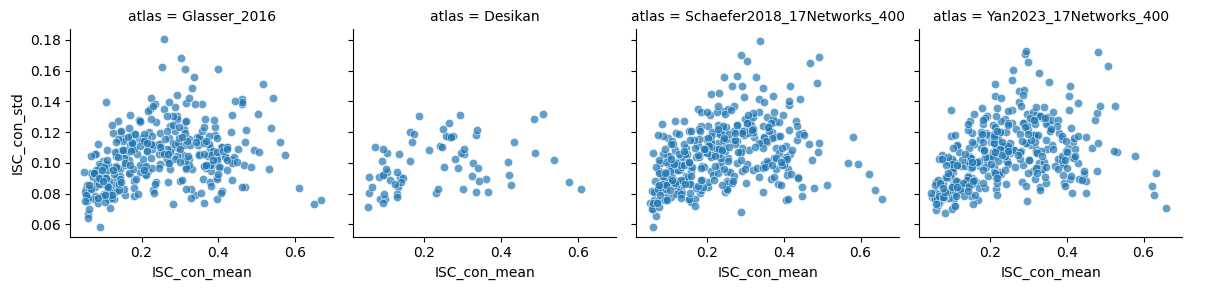

In [17]:
ax = sns.scatterplot(data=df, x='ISC_con_mean', y='ISC_con_std', size='ISC_con_nlogcv', hue='atlas')
# sns.lineplot(x=[0, 1], y=[0, 1])
sns.move_legend(ax, loc='upper left',bbox_to_anchor=(1, 1))
ax.set_xlim([df['ISC_con_mean'].min(), df['ISC_con_mean'].max()])
ax.set_ylim([df['ISC_con_std'].min(), df['ISC_con_std'].max()])

g = sns.FacetGrid(df, col="atlas")
g.map(sns.scatterplot, "ISC_con_mean", "ISC_con_std", alpha=.7)
g.add_legend()

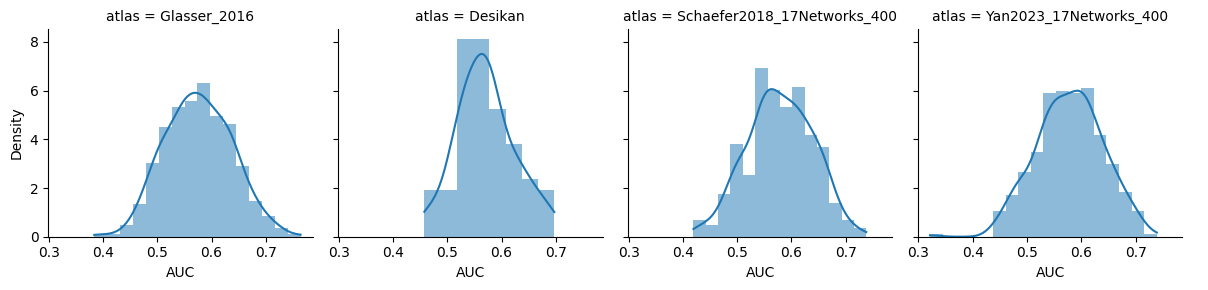

In [18]:
g = sns.FacetGrid(data=df, col='atlas')
g.map(sns.histplot, "AUC", stat='density', ec=None, kde=True)
g.add_legend()

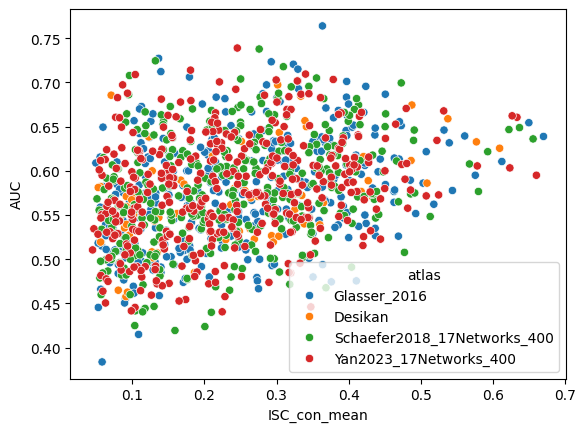

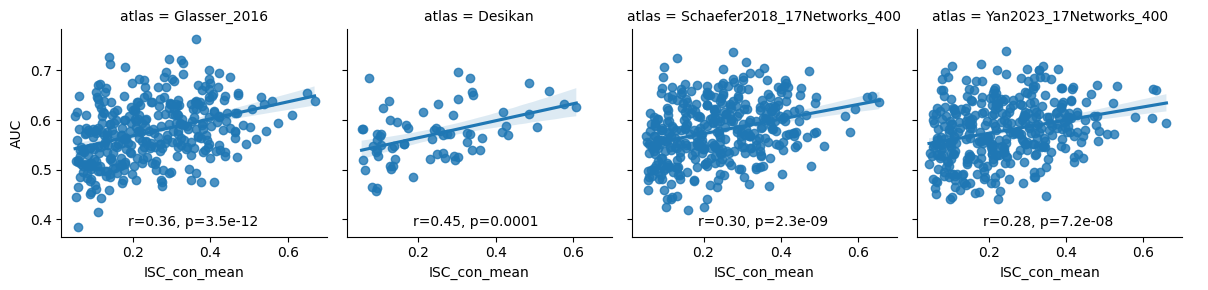

In [19]:
def annotate(x,y, **kws):
    ind = ~(np.isnan(x)|np.isnan(y))
    x = x[ind]
    y = y[ind]
    r, p = sp.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.text(.25, .05, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

sns.scatterplot(data=df, x='ISC_con_mean', y='AUC', hue='atlas')
g = sns.FacetGrid(df, col="atlas")
g.map(sns.regplot, "ISC_con_mean", "AUC")
g.map(annotate, "ISC_con_mean", "AUC")
g.add_legend()

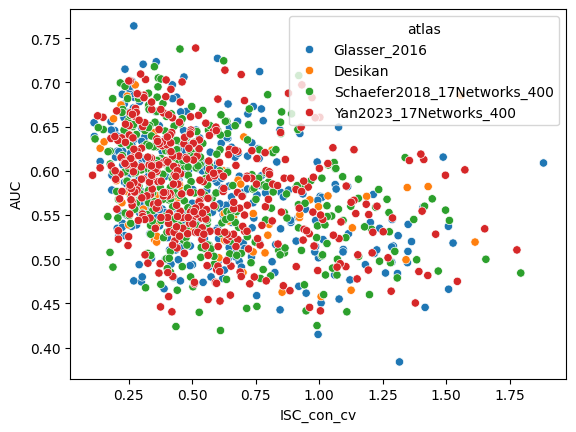

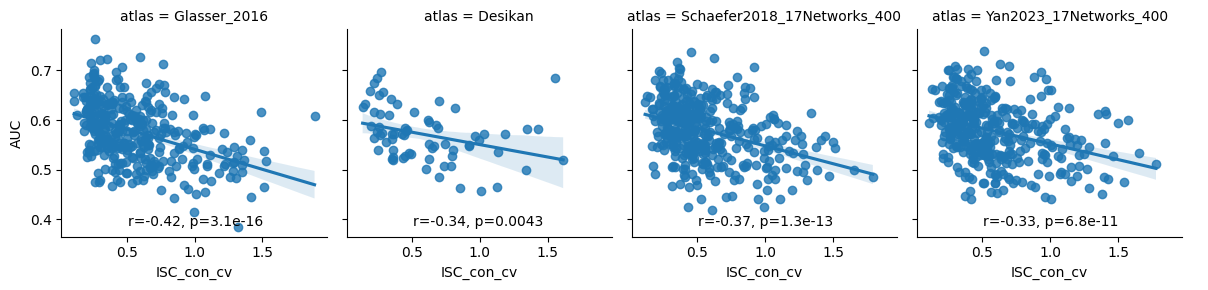

In [20]:
sns.scatterplot(data=df, x='ISC_con_cv', y='AUC', hue='atlas')

g = sns.FacetGrid(df, col="atlas")
g.map(sns.regplot, "ISC_con_cv", "AUC")
g.map(annotate, "ISC_con_cv", "AUC")
g.add_legend()

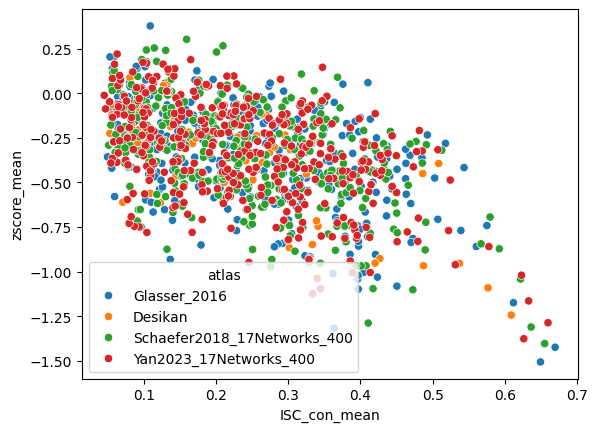

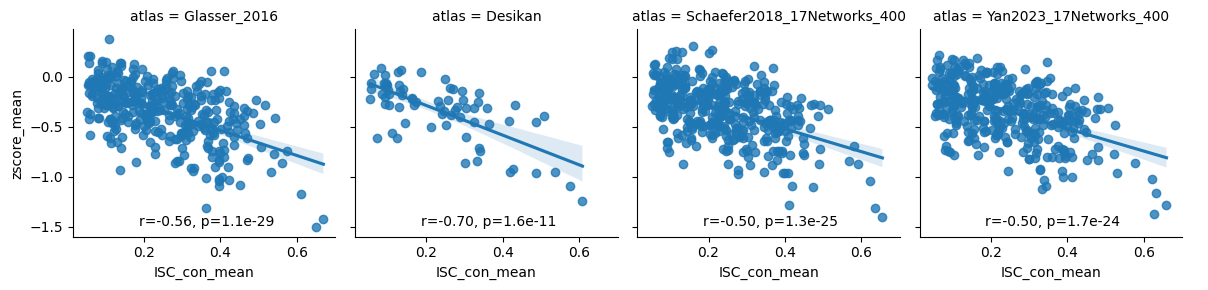

In [21]:
x = 'ISC_con_mean'
y = 'zscore_mean'
sns.scatterplot(data=df, x=x, y=y, hue='atlas')

g = sns.FacetGrid(df, col="atlas")
g.map(sns.regplot, x, y)
g.map(annotate, x, y)
g.add_legend()

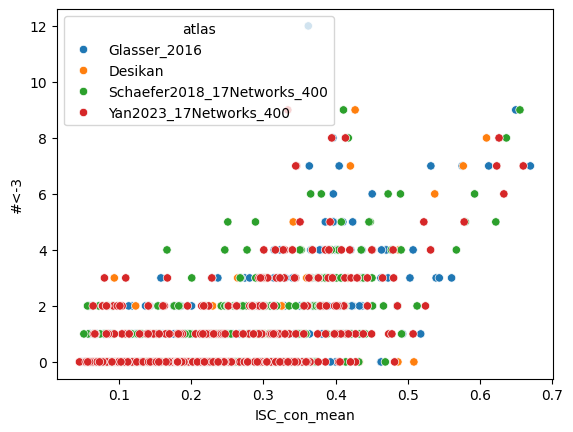

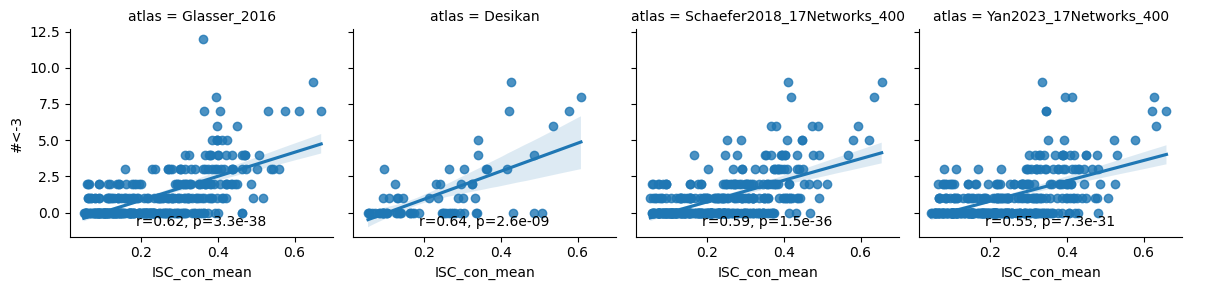

In [22]:
x = 'ISC_con_mean'
y = '#<-3'
sns.scatterplot(data=df, x=x, y=y, hue='atlas')

g = sns.FacetGrid(df, col="atlas")
g.map(sns.regplot, x, y)
g.map(annotate, x, y)
g.add_legend()

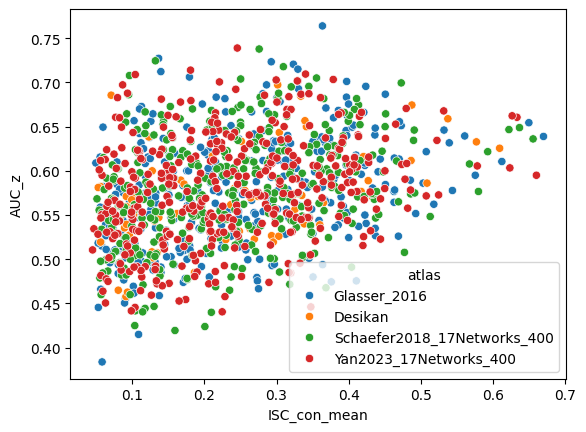

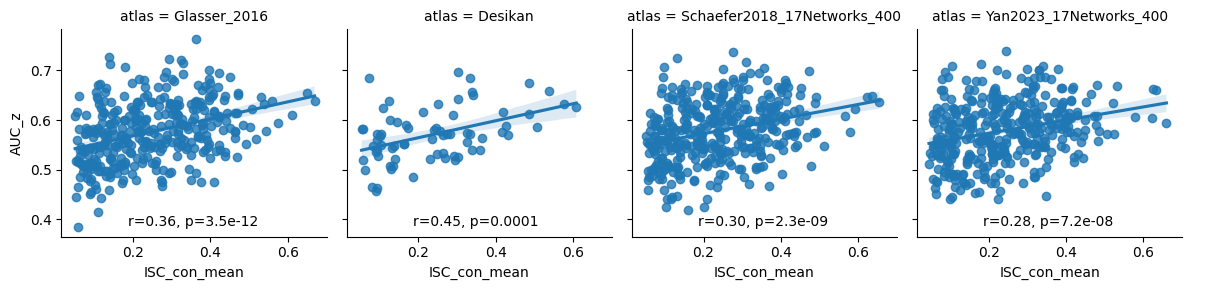

In [23]:
x = 'ISC_con_mean'
y = 'AUC_z'
sns.scatterplot(data=df, x=x, y=y, hue='atlas')

g = sns.FacetGrid(df, col="atlas")
g.map(sns.regplot, x, y)
g.map(annotate, x, y)
g.add_legend()